[![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/aws/sagemaker/sagemaker-pinecone-rag.ipynb)

# Image Classification using Pinecone and Amazon Bedrock


| | |
|-|-|
|Author | [Vamshi Enabothala](https://github.com/vkrishna1084) |

In this notebook we will demonstrate how to use Pinecone with Bedrock to perform Image Classification on a corpus of images, by using image embeddings and retrieval. The embeddings are generated using Amazon Titan Multimodal Embedding model (amazon.titan-embed-image-v1) and retrieved from [**Pinecone Vector Database**](https://www.pinecone.io/). 
Access to a Pinecone environment and Amazon Bedrock is a prerequisite to run this notebook fully. 

**You can start by using the [Free Tier on Pinecone](https://www.pinecone.io/pricing/). This notebook serves a template such that you can easily replace the example dataset by your own to build a custom image classification application.**


**Why use a Vector Database for Classification?**

Image classification is a fundamental task in computer vision that involves assigning a label or category to an input image. One powerful approach to image classification is the use of vector embeddings, which represent images as high-dimensional numerical vectors.

These vector embeddings capture the underlying semantic and visual properties of the images, enabling efficient storage, retrieval, and comparison.

A vector database stores data points in a way that semantically similar points are positioned closer together in the latent space, while dissimilar points are farther apart. This allows for the given vector embedding of an object to be matched with similar vectors in the database, helping to identify which group it belongs to and determine its label

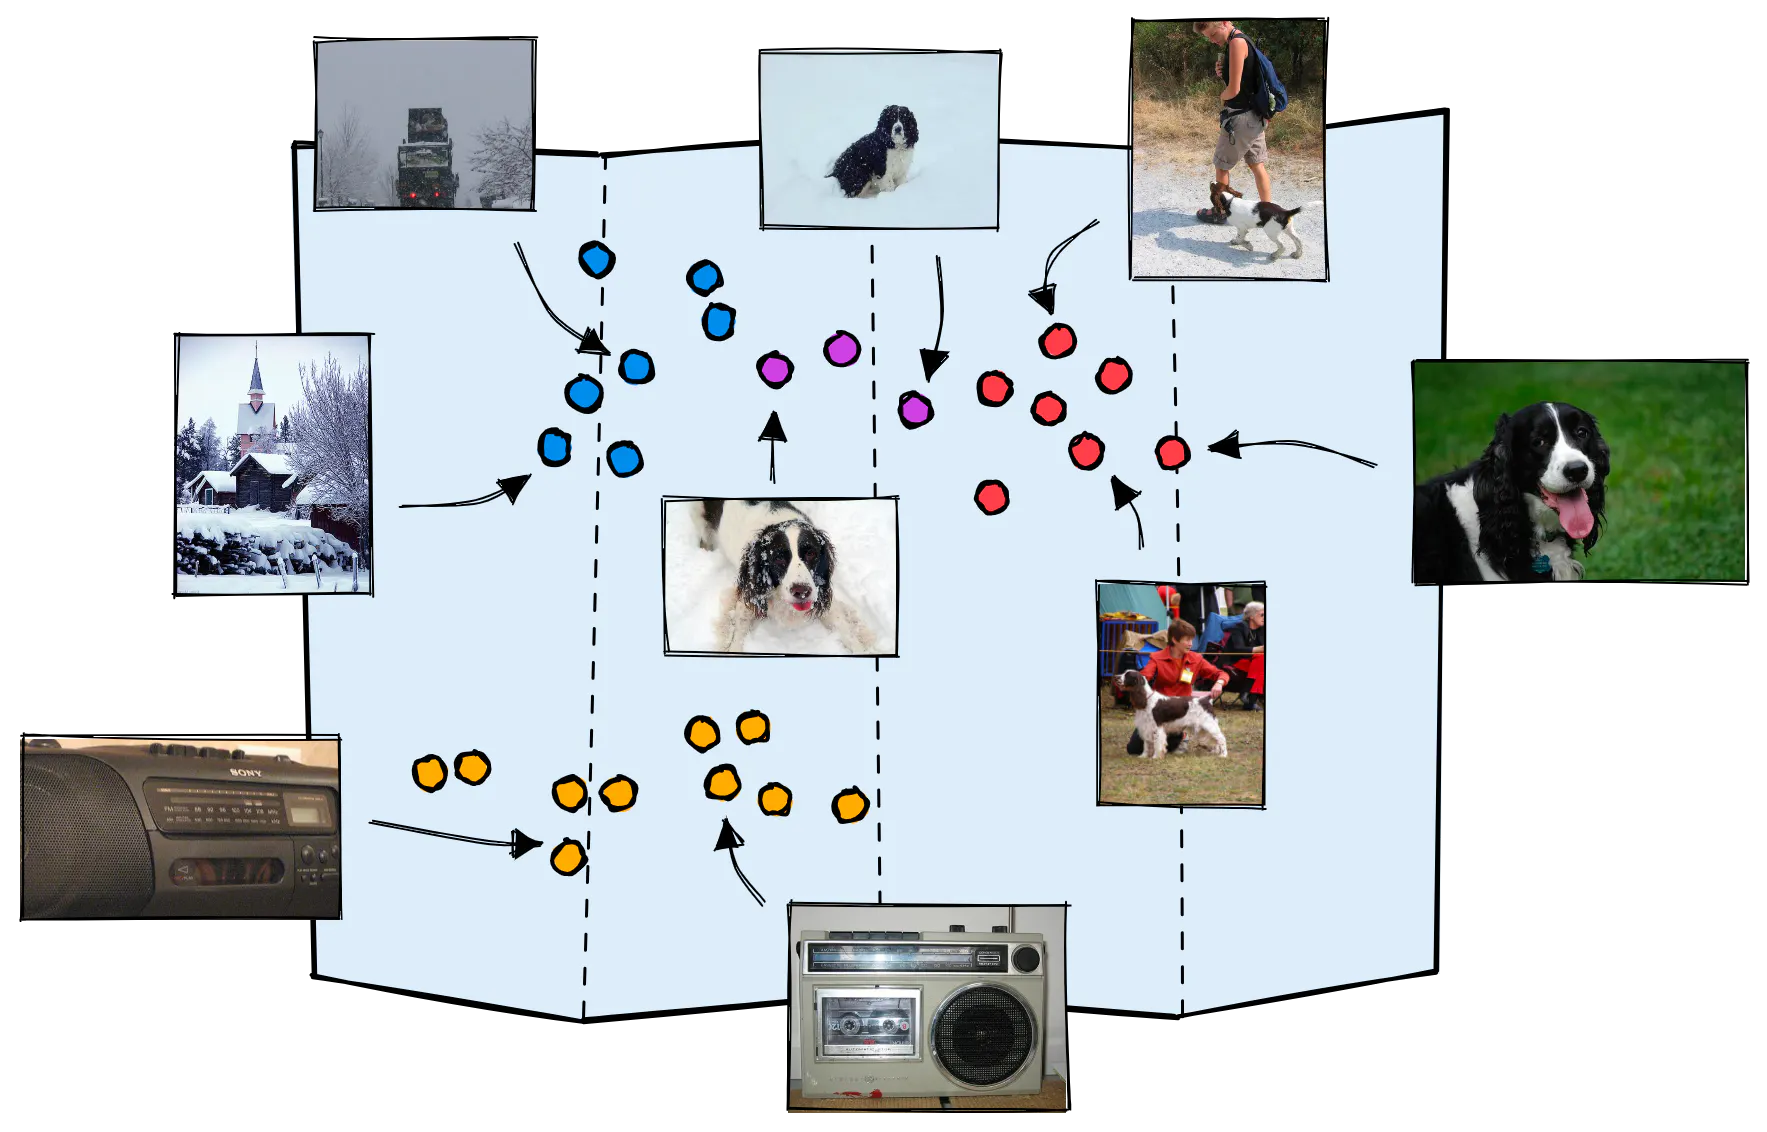

********************************************************** GETTING STARTED **********************************************************

#### Step 1. Install required libraries, Initialize Bedrock and Pinecone
#### Step 2. Download the Images Dataset
#### Step 3. Index the data into Pinecone Index
#### Step 4. Perform Image Classification

*******************************************************************************************************************

### Step 1. Install required libraries, Initialize Bedrock and Pinecone

In [ ]:
pip install pinecone-client boto3 datasets transformers tqdm Pillow

To begin, we will initialize Amazon Bedrock and Pinecone that we'll need to use throughout the walkthrough.

In [ ]:
import json
import boto3
import botocore
from botocore.config import Config
import time
from pinecone import ServerlessSpec
from pinecone import Pinecone
import base64
from io import BytesIO

#### Use the instruction provided in the link to add Amazon Bedrock permissions to the IAM role that will use this SageMaker notebook [Using SageMaker Notebooks](https://docs.aws.amazon.com/bedrock/latest/userguide/api-setup.html#api-using-sage).

In [ ]:
config = Config(connect_timeout=5, read_timeout=60, retries={"total_max_attempts": 20, "mode": "adaptive"})
region = 'us-east-1'

bedrock = boto3.client(
                service_name='bedrock-runtime',
                region_name=region,
                endpoint_url=f'https://bedrock-runtime.{region}.amazonaws.com',
                                    config=config)

In [ ]:
def generate_embeddings_with_titan(image=None, text=None):
    try: 
        user_input = {}

        if image is not None:
            user_input["inputImage"] = image
        if text is not None:
            user_input["inputText"] = text

        if not user_input:
            raise ValueError("One user input of an image or a text is required")

        body = json.dumps(user_input)

        response = bedrock.invoke_model(
            body=body,
            modelId="amazon.titan-embed-image-v1",
            accept="application/json",
            contentType="application/json"
        )

        response_body = json.loads(response.get("body").read())

        embedding_error = response_body.get("message")

        #if finish_reason is not None:
        #    raise EmbedError(f"Embeddings generation error: {embedding_error}")

        return response_body.get("embedding")
    except Exception:
        pass
    #except botocore.exceptions.ClientError as error:
    #    raise error

In [ ]:
pinecone_api_key = 'PINECONE_API_KEY' #provide your Pinecone API Key

In [ ]:
pc = Pinecone(api_key=pinecone_api_key)
spec = ServerlessSpec(cloud='aws', region='us-west-2')

## Step 2. Download the Images dataset

Lets download the images dataset!

In [ ]:
from datasets import load_dataset

imagenet = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train[:1%]+train[20%:21%]+train[40%:41%]+train[60%:61%]+train[80%:81%]', # To load Full Dataset use split='train' or for a subset use split='train[:1%]+train[20%:21%]+train[40%:41%]+train[60%:61%]+train[80%:81%]'
    ignore_verifications=True  # set to True if seeing splits Error
)
imagenet


In [ ]:
imagenet[400]['image']

In [ ]:
imagenet.features['label'].int2str(imagenet[400]['label'])

In [ ]:
#with open('Pinecone_Logo.png', "rb") as image_file:
#     input_image = base64.b64encode(image_file.read()).decode('utf8')

In [ ]:
#resp = generate_embeddings_with_titan(image=input_image)
#print (str(resp))

## Step 3. Index the data into Pinecone Index

For all the images in the dataset, generate vector embeddings using Amazon Titan multimodal embedding model and insert into a Pinecone index along with their label as metadata.

In [ ]:
index_name = 'pinecone-bedrock-multimodal'
namespace = 'image-classification'

In [ ]:
# get existing indexes
existing_indexes = pc.list_indexes().names()

# check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=1024,  
        metric='dotproduct',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
print(index.describe_index_stats())

In [ ]:
def image_embed(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    image_str = base64.b64encode(buffered.getvalue()).decode('utf8')
    image_emd = generate_embeddings_with_titan(image=image_str, text=None)
    return image_emd

Note: Loading the entire dataset of ~9500 images would take around 40 to 60 minutes

In [ ]:
from tqdm.auto import tqdm

for i in tqdm(range(0,len(imagenet))):
    print(i)
    metadatas = {"label": imagenet.features['label'].int2str(imagenet[i]['label'])}
    #imagenet[i]['image']
    print(metadatas)
    # create embeddings
    embeds = image_embed(imagenet[i]['image'])
    #print(len(embeds))
    #print(str(embeds))
    # upsert to Pinecone
    if embeds is not None:
        index.upsert(vectors=[{"id": str(i), "values": embeds, "metadata": metadatas}],namespace=namespace)
    else: 
        print("Failed to generate embeddings")


In [ ]:
# view index stats
print(index.describe_index_stats())

## Step 4. Perform Image Classification

To perform Image Classification, the query image is processed through the Amazon Titan multimodal embedding model to generate its vector embedding. Then the embeddings are compared with all the image embeddings in the Pinecone database using similarity search. This identifies images whose embeddings are closest to the query image embedding in the vector space.

In [ ]:
test_imagenet = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='validation',
    ignore_verifications=True  # set to True if seeing splits Error
)
test_imagenet

In [ ]:
test_imagenet[20]['image']

In [ ]:
test_imagenet.features['label'].int2str(test_imagenet[20]['label'])

In [ ]:
query_vector = image_embed(test_imagenet[20]['image'])
res = index.query(vector=query_vector, top_k=5, namespace=namespace,include_metadata=True)
res

In [ ]:
imagenet[19]['image']

In [ ]:
imagenet[75]['image']

Now you can see the generated search results category (labels) are closely matching with the query image category.

In this notebook, we demonstrated the step-by-step creation of a image classification using Pinecone and Amazon Bedrock. This solution allows you to classify new images based on similarities to pre-labeled images without any requirement of machine learning training.

---